In [1]:
import pandas as pd
import requests
import numpy as np
from datetime import date
import yfinance as yf
import matplotlib.pyplot as plt
import streamlit as st

In [2]:
START = "2015-01-01"
TODAY = date.today().strftime("%Y-%m-%d")
stocks = ('GME')
selected_stock = st.selectbox('Select dataset for prediction', stocks)

2023-11-13 19:57:05.625 
  command:

    streamlit run C:\Users\Shahan\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py [ARGUMENTS]


In [3]:
def load_data(ticker):
    data = yf.download('BTC-USD', START, TODAY)
    data.reset_index(inplace=True)
    return data

In [4]:
data = load_data(stocks)

[*********************100%%**********************]  1 of 1 completed


In [5]:
data.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
1,2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2,2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
3,2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
4,2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800


In [6]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3233,2023-11-08,35419.476562,35994.417969,35147.800781,35655.277344,35655.277344,17295394918
3234,2023-11-09,35633.632812,37926.257812,35592.101562,36693.125000,36693.125000,37762672382
3235,2023-11-10,36702.250000,37493.800781,36362.753906,37313.968750,37313.968750,22711265155
3236,2023-11-11,37310.070312,37407.093750,36773.667969,37138.050781,37138.050781,13924272142
3237,2023-11-12,37133.992188,37227.691406,36779.117188,37054.519531,37054.519531,11545715999


In [7]:
data = data.reset_index()
data.head()

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2015-01-01,320.434998,320.434998,314.002991,314.248993,314.248993,8036550
1,1,2015-01-02,314.079010,315.838989,313.565002,315.032013,315.032013,7860650
2,2,2015-01-03,314.846008,315.149994,281.082001,281.082001,281.082001,33054400
3,3,2015-01-04,281.145996,287.230011,257.612000,264.195007,264.195007,55629100
4,4,2015-01-05,265.084015,278.341003,265.084015,274.473999,274.473999,43962800


In [8]:
data = data.drop(["Date","Adj Close"], axis=1)
data.head()

,index,Open,High,Low,Close,Volume
0,0,320.434998,320.434998,314.002991,314.248993,8036550
1,1,314.079010,315.838989,313.565002,315.032013,7860650
2,2,314.846008,315.149994,281.082001,281.082001,33054400
3,3,281.145996,287.230011,257.612000,264.195007,55629100
4,4,265.084015,278.341003,265.084015,274.473999,43962800


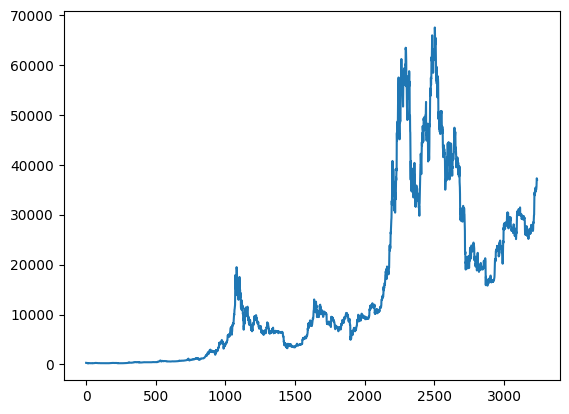

In [9]:
plt.plot(data.Close)

In [10]:
ma100 = data.Close.rolling(100).mean()
ma100

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
            ...     
3233    28564.290020
3234    28634.463945
3235    28716.084043
3236    28795.677754
3237    28875.482031
Name: Close, Length: 3238, dtype: float64

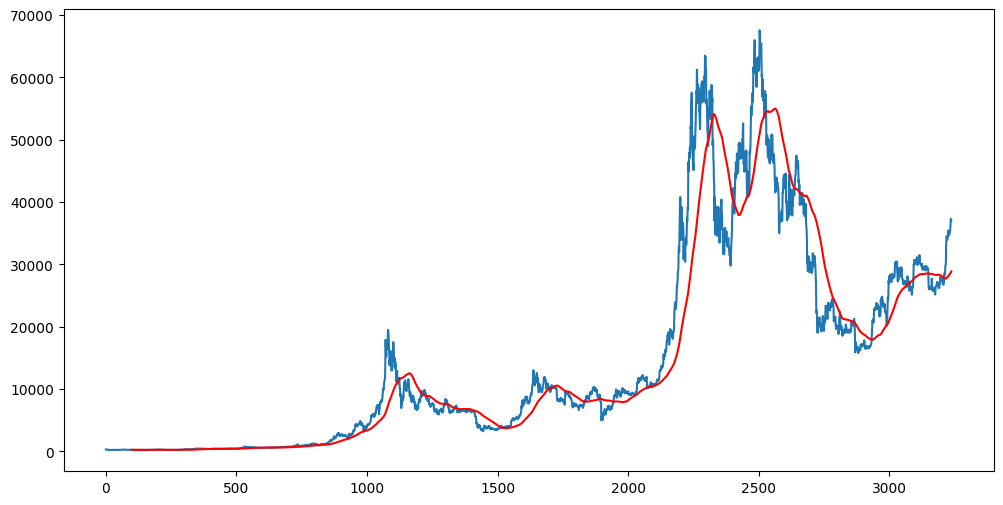

In [11]:
plt.figure(figsize = (12,6))
plt.plot(data.Close)
plt.plot(ma100,'r')

In [12]:
data.shape

(3238, 6)

In [13]:
data_training = pd.DataFrame(data['Close'][0:int(len(data)*0.70)])
data_testing = pd.DataFrame(data['Close'][int(len(data)*0.70):int(len(data))])

print(data_training.shape)
print(data_testing.shape)

(2266, 1)
(972, 1)


In [14]:
data_training.tail()

,Close
2261,57805.121094
2262,57332.089844
2263,61243.085938
2264,59302.316406
2265,55907.199219


In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [16]:
data_training_array = scaler.fit_transform(data_training)
data_training_array

array([[0.00222953],
       [0.00224235],
       [0.00168638],
       ...,
       [1.        ],
       [0.96821796],
       [0.91261953]])

In [17]:
data_training_array.shape

(2266, 1)

In [18]:
x_train = []
y_train = []

for i in range (100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape

(2166, 100, 1)

In [19]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [20]:
model = Sequential()
model.add(LSTM(units = 20, activation = 'relu', return_sequences = True, 
               input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 40, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))
model.add(LSTM(units = 90, activation = 'relu'))
model.add(Dropout(0.5))

#model density
model.add(Dense(units=3))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 20)           1760      
                                                                 
 dropout (Dropout)           (None, 100, 20)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 40)           9760      
                                                                 
 dropout_1 (Dropout)         (None, 100, 40)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 60)           24240     
                                                                 
 dropout_2 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_3 (LSTM)               (None, 90)                5

In [22]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=100)

Epoch 1/100
68/68 [==============================] - 13s 123ms/step - loss: 0.0279
Epoch 2/100
68/68 [==============================] - 10s 140ms/step - loss: 0.0139
Epoch 3/100
68/68 [==============================] - 9s 133ms/step - loss: 0.0065
Epoch 4/100
68/68 [==============================] - 10s 143ms/step - loss: 0.0029
Epoch 5/100
68/68 [==============================] - 9s 134ms/step - loss: 0.0024
Epoch 6/100
68/68 [==============================] - 10s 148ms/step - loss: 0.0024
Epoch 7/100
68/68 [==============================] - 10s 143ms/step - loss: 0.0020
Epoch 8/100
68/68 [==============================] - 10s 140ms/step - loss: 0.0025
Epoch 9/100
68/68 [==============================] - 9s 138ms/step - loss: 0.0022
Epoch 10/100
68/68 [==============================] - 9s 133ms/step - loss: 0.0017
Epoch 11/100
68/68 [==============================] - 9s 136ms/step - loss: 0.0018
Epoch 12/100
68/68 [==============================] - 9s 138ms/step - loss: 0.0017
Epoch 1

In [23]:
model.save('final_model.h5')

c:\Users\Shahan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
data_testing.head()

,Close
2266,56804.902344
2267,58870.894531
2268,57858.921875
2269,58346.652344
2270,58313.644531


In [25]:
data_testing.tail(100)

,Close
3138,29042.126953
3139,29041.855469
3140,29180.578125
3141,29765.492188
3142,29561.494141
...,...
3233,35655.277344
3234,36693.125000
3235,37313.968750
3236,37138.050781


In [26]:
past_data_100days = data_testing.tail(100)

In [27]:
final_data = past_data_100days.append(data_testing, ignore_index=True)

C:\Users\Shahan\AppData\Local\Temp\ipykernel_24248\3568412603.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_data = past_data_100days.append(data_testing, ignore_index=True)


In [28]:
final_data.head()

,Close
0,29042.126953
1,29041.855469
2,29180.578125
3,29765.492188
4,29561.494141


In [29]:
input_data = scaler.fit_transform(final_data)
input_data

array([[0.25598609],
       [0.25598084],
       [0.25865994],
       ...,
       [0.41573724],
       [0.4123398 ],
       [0.41072659]])

In [30]:
input_data.shape

(1072, 1)

In [31]:
x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100: i])
    y_test.append(input_data[i,0])

In [32]:
x_test, y_test = np.array(x_test), np.array(y_test)
y_test.shape

(972,)

In [33]:
print(x_test)

[[[0.25598609]
  [0.25598084]
  [0.25865994]
  ...
  [0.41573724]
  [0.4123398 ]
  [0.41072659]]

 [[0.25598084]
  [0.25865994]
  [0.26995618]
  ...
  [0.4123398 ]
  [0.41072659]
  [0.79215874]]

 [[0.25865994]
  [0.26995618]
  [0.26601644]
  ...
  [0.41072659]
  [0.79215874]
  [0.83205851]]

 ...

 [[0.25810723]
  [0.25862328]
  [0.25660341]
  ...
  [0.37961474]
  [0.38370352]
  [0.4037471 ]]

 [[0.25862328]
  [0.25660341]
  [0.25598609]
  ...
  [0.38370352]
  [0.4037471 ]
  [0.41573724]]

 [[0.25660341]
  [0.25598609]
  [0.25598084]
  ...
  [0.4037471 ]
  [0.41573724]
  [0.4123398 ]]]


In [34]:
predicted_value = model.predict(x_test)

31/31 [==============================] - 2s 39ms/step


In [35]:
predicted_value.shape

(972, 3)

In [36]:
sc = scaler.scale_
sc

array([1.9312646e-05])

In [37]:
scale_factor = 1/sc
predicted_value = predicted_value * scale_factor
y_test = y_test * scale_factor

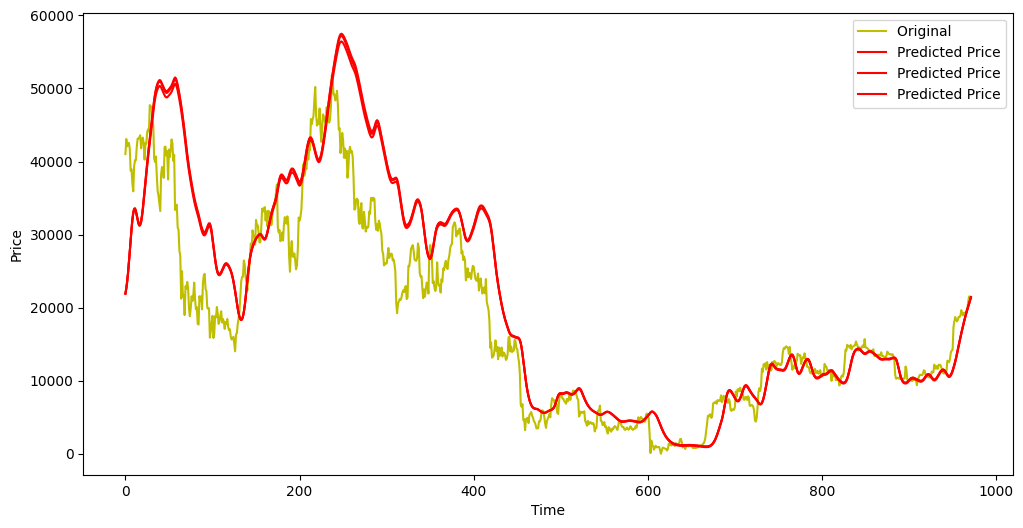

In [38]:
plt.figure(figsize=(12,6))
plt.plot(y_test, 'y', label = 'Original ')
plt.plot(predicted_value, 'r', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
